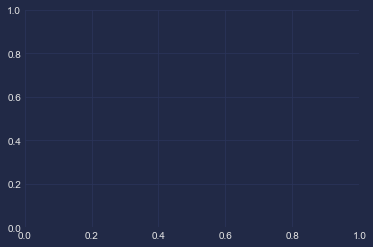

In [43]:
from data_loader.load import load_pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mplcyberpunk
plt.style.use("cyberpunk")
mplcyberpunk.make_lines_glow()


## Load data and filter duplicates


In [44]:
main_data18 = load_pd("../data/kd2018.csv", ";")
main_data19 = load_pd("../data/kd2019.csv", ";")
main_data20 = load_pd("../data/kd2020.csv", ";")
main_data21 = load_pd("../data/kd2021.csv", ";")

main_data18_filtered = main_data18.drop_duplicates(["ZaporednaStevilkaKD"])
main_data19_filtered = main_data19.drop_duplicates(["ZaporednaStevilkaKD"])
main_data20_filtered = main_data20.drop_duplicates(["ZaporednaStevilkaKD"])
main_data21_filtered = main_data21.drop_duplicates(["ZaporednaStevilkaKD"])

np.warnings.filterwarnings('ignore')
main_data19_filtered["ZaporednaStevilkaKD"] += main_data18_filtered["ZaporednaStevilkaKD"].max()
main_data20_filtered["ZaporednaStevilkaKD"] += main_data19_filtered["ZaporednaStevilkaKD"].max()
main_data21_filtered["ZaporednaStevilkaKD"] += main_data20_filtered["ZaporednaStevilkaKD"].max()
main_data = pd.concat([main_data18_filtered, main_data19_filtered,
                      main_data20_filtered, main_data21_filtered])


In [45]:
time_of_day_map: dict = dict.fromkeys(main_data["UraStoritve"].unique())
main_data["UraStoritve"].unique()


array(['15:00-15:59', '00:00-00:59', '23:00-23:59', '17:00-17:59',
       '11:00-11:59', '10:00-10:59', '13:00-13:59', '07:00-07:59',
       '19:00-19:59', '09:00-09:59', '14:00-14:59', '18:00-18:59',
       '12:00-12:59', '22:00-22:59', '20:00-20:59', '03:00-03:59',
       '16:00-16:59', '08:00-08:59', '21:00-21:59', '02:00-02:59',
       '01:00-01:59', '04:00-04:59', '06:00-06:59', '05:00-05:59'],
      dtype=object)

In [46]:
time_of_day_map['15:00-15:59'] = "afternoon"
time_of_day_map['00:00-00:59'] = "night"
time_of_day_map['23:00-23:59'] = "night"
time_of_day_map['17:00-17:59'] = "afternoon"
time_of_day_map['11:00-11:59'] = "morning"
time_of_day_map['10:00-10:59'] = "morning"
time_of_day_map['13:00-13:59'] = "afternoon"
time_of_day_map['07:00-07:59'] = "morning"
time_of_day_map['19:00-19:59'] = "evening"
time_of_day_map['09:00-09:59'] = "morning"
time_of_day_map['14:00-14:59'] = "afternoon"
time_of_day_map['18:00-18:59'] = "evening"
time_of_day_map['12:00-12:59'] = "afternoon"
time_of_day_map['22:00-22:59'] = "night"
time_of_day_map['20:00-20:59'] = "evening"
time_of_day_map['03:00-03:59'] = "night"
time_of_day_map['16:00-16:59'] = "afternoon"
time_of_day_map['08:00-08:59'] = "morning"
time_of_day_map['21:00-21:59'] = "night"
time_of_day_map['02:00-02:59'] = "night"
time_of_day_map['01:00-01:59'] = "night"
time_of_day_map['04:00-04:59'] = "morning"
time_of_day_map['06:00-06:59'] = "morning"
time_of_day_map['05:00-05:59'] = "morning"


## Največ kriminala je v času:


<BarContainer object of 4 artists>

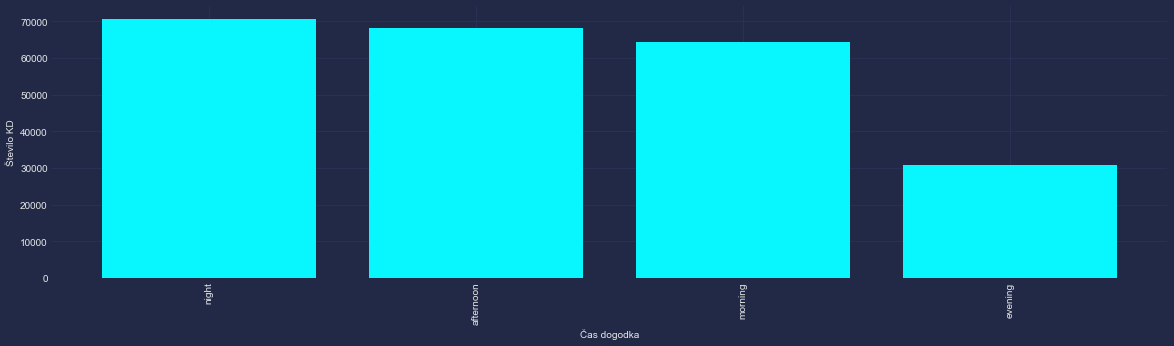

In [47]:
plt.figure(figsize=(20, 5))
plt.xticks(rotation=90)
plt.xlabel('Čas dogodka')
plt.ylabel('Število KD')

count_per_time_of_day = main_data.groupby("UraStoritve").count()[
    "ZaporednaStevilkaKD"].sort_values(ascending=False)
count_per_time_of_day.index = count_per_time_of_day.index.map(
    lambda TOD: time_of_day_map[TOD])
count_per_time_of_day = count_per_time_of_day.groupby(
    level=0).sum().sort_values(ascending=False)
plt.bar(count_per_time_of_day.index, count_per_time_of_day.values)


## Load kazni dict


In [48]:
import json
# read json data from kazni_dict.json
with open('../data/kazni_dict.json', 'r', encoding='utf8') as f:
    kazni_dict = json.load(f)

kazni_utezi = dict()
for kd, values in kazni_dict.items():
    if (pd.isna(values['average_actual_jailtime'])):
        x = values['max_jailtime'] * 2 * values['dangerousness']
    else:
        x = (values['max_jailtime'] +
             values['average_actual_jailtime']) * values['dangerousness']
    kazni_utezi[kd] = x


In [49]:
from collections import defaultdict
nevarnost_by_tod: dict = dict.fromkeys(count_per_time_of_day.index, 0)
kd_errors_dict = defaultdict(int)


for i, kd in main_data.iterrows():
    tod = time_of_day_map[kd["UraStoritve"]]
    kd = str.lower(str.strip(str.split(kd["OpisKD"], '-')[-1]))

    try:
        nevarnost_by_tod[tod] += kazni_utezi[kd]
    except KeyError:
        kd_errors_dict[kd] += 1
        # print(f"NAPAKA PRI \"TOD: {tod}, KD: {kd}\"")


## Prikaz danger by Time of day

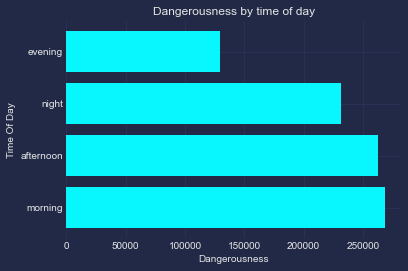

In [50]:
np_tod_danger = np.array(list(nevarnost_by_tod.items()), dtype=object)
np_tod_danger = np_tod_danger[np.argsort(np_tod_danger[:, 1])[::-1]]
# print(np_regije_danger)
# create graph of dangerousness of regions

fig, ax = plt.subplots()
ax.barh(np_tod_danger[:, 0], np_tod_danger[:, 1])
ax.set_xlabel('Dangerousness')
ax.set_ylabel('Time Of Day')
ax.set_title('Dangerousness by time of day')
plt.show()


## Normalized by number of Kds in Time of day

In [51]:
# normalize np_tod_danger with count_per_time_of_day
normalized_np_tod_danger = np_tod_danger.copy()
normalized_np_tod_danger[:, 1] = np_tod_danger[:, 1] / count_per_time_of_day.values
normalized_np_tod_danger = normalized_np_tod_danger[np.argsort(normalized_np_tod_danger[:, 1])[::-1]]

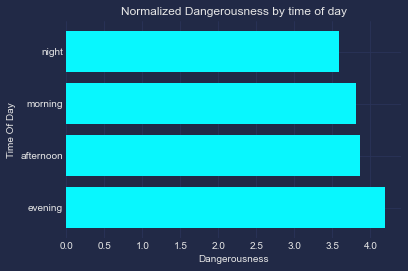

In [52]:
#plot np_tod_danger
fig, ax = plt.subplots()
ax.barh(normalized_np_tod_danger[:, 0], normalized_np_tod_danger[:, 1])
ax.set_xlabel('Dangerousness')
ax.set_ylabel('Time Of Day')
ax.set_title('Normalized Dangerousness by time of day')
plt.show()

Je nekoliko manj odstopanja, kot bi pričakoval.
Ponoči sem mislil da bo bolj nevarno kot npr zjutraj, ampak ni

## Export data

In [53]:
export_dict = {tod: dangerousness for tod, dangerousness in normalized_np_tod_danger}

In [54]:
json.dump(export_dict, open("../data/danger_by_tod.json", "w"))

## Nevarnost glede na čas, brez grupiranja

In [55]:
n_count_per_time_of_day = main_data.groupby("UraStoritve").count()["ZaporednaStevilkaKD"].sort_values(ascending=False)

In [56]:
from collections import defaultdict
no_group_nevarnost_by_tod: dict = dict.fromkeys(main_data["UraStoritve"].unique(), 0)
kd_errors_dict = defaultdict(int)


for i, kd in main_data.iterrows():
    tod = kd["UraStoritve"]
    kd = str.lower(str.strip(str.split(kd["OpisKD"], '-')[-1]))

    try:
        no_group_nevarnost_by_tod[tod] += kazni_utezi[kd]
    except KeyError:
        kd_errors_dict[kd] += 1
        # print(f"NAPAKA PRI \"TOD: {tod}, KD: {kd}\"")

## Prikaz rezultatov

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


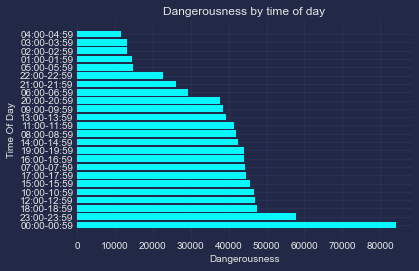

In [57]:
n_np_tod_danger = np.array(list(no_group_nevarnost_by_tod.items()), dtype=object)
n_np_tod_danger = n_np_tod_danger[np.argsort(n_np_tod_danger[:, 1])[::-1]]
# print(np_regije_danger)
# create graph of dangerousness of regions

fig, ax = plt.subplots()
ax.barh(n_np_tod_danger[:, 0], n_np_tod_danger[:, 1])
ax.set_xlabel('Dangerousness')
ax.set_ylabel('Time Of Day')
ax.set_title('Dangerousness by time of day')
plt.show()


In [58]:
n_normalized_np_tod_danger = n_np_tod_danger.copy()
n_normalized_np_tod_danger[:, 1] = n_np_tod_danger[:, 1] / n_count_per_time_of_day.values
n_normalized_np_tod_danger = n_normalized_np_tod_danger[np.argsort(n_normalized_np_tod_danger[:, 1])[::-1]]

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


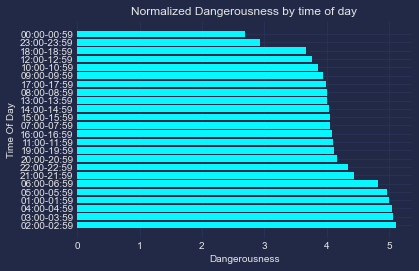

In [59]:
#plot np_tod_danger
fig, ax = plt.subplots();
ax.barh(n_normalized_np_tod_danger[:, 0], n_normalized_np_tod_danger[:, 1]);
ax.set_xlabel('Dangerousness');
ax.set_ylabel('Time Of Day');
ax.set_title('Normalized Dangerousness by time of day');
plt.show();

### Sort by time not by value

In [60]:
indexes = list(n_normalized_np_tod_danger[:, 0])
indexes.sort(key=lambda x: int(x[:2]))

In [61]:
sorted_np_tod_danger = n_normalized_np_tod_danger[np.argsort(n_normalized_np_tod_danger[:, 0])]

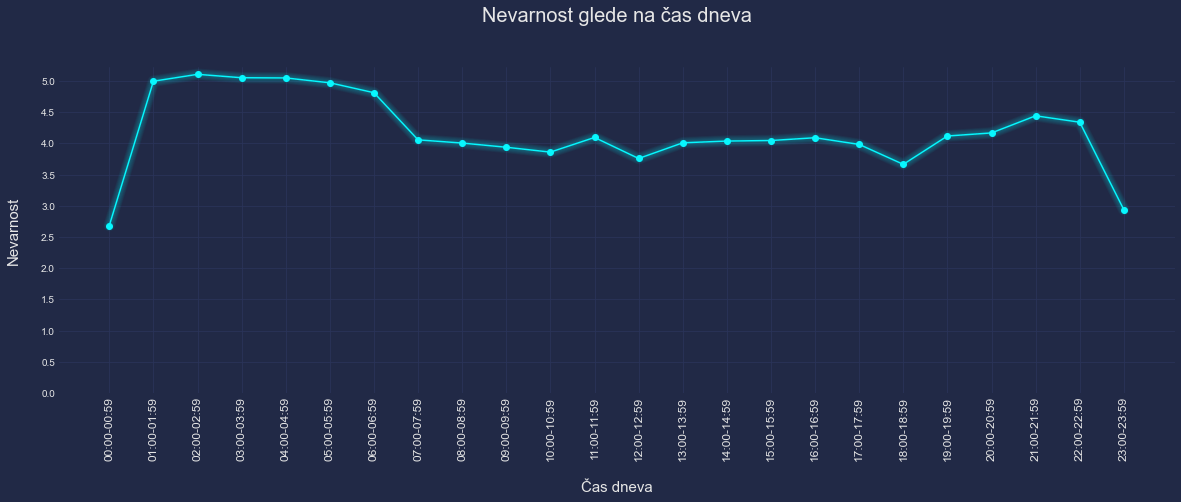

In [94]:
fig, ax = plt.subplots(figsize=(20, 6))

# fig.patch.set_facecolor('white')
ax.plot(sorted_np_tod_danger[:, 1], marker="o")
mplcyberpunk.make_lines_glow()
# mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.5)

ax.set_xticklabels(sorted_np_tod_danger[:, 0], rotation=90, fontsize=12)
ax.set_xticks(np.arange(len(sorted_np_tod_danger[:, 0])))
ax.set_xlabel('Čas dneva', labelpad=20, fontsize=15)
ax.set_yticks(np.arange(0, max(sorted_np_tod_danger[:,1])+.3, 0.5))

ax.set_ylabel('Nevarnost', labelpad=20, fontsize=15)
ax.set_title('Nevarnost glede na čas dneva', y=1.12, fontsize=20)

plt.show()


In [83]:
print(sorted_np_tod_danger[0])

['00:00-00:59' 2.6824759021448394]
